In [1]:
import sys
# setting path
sys.path.append('../')

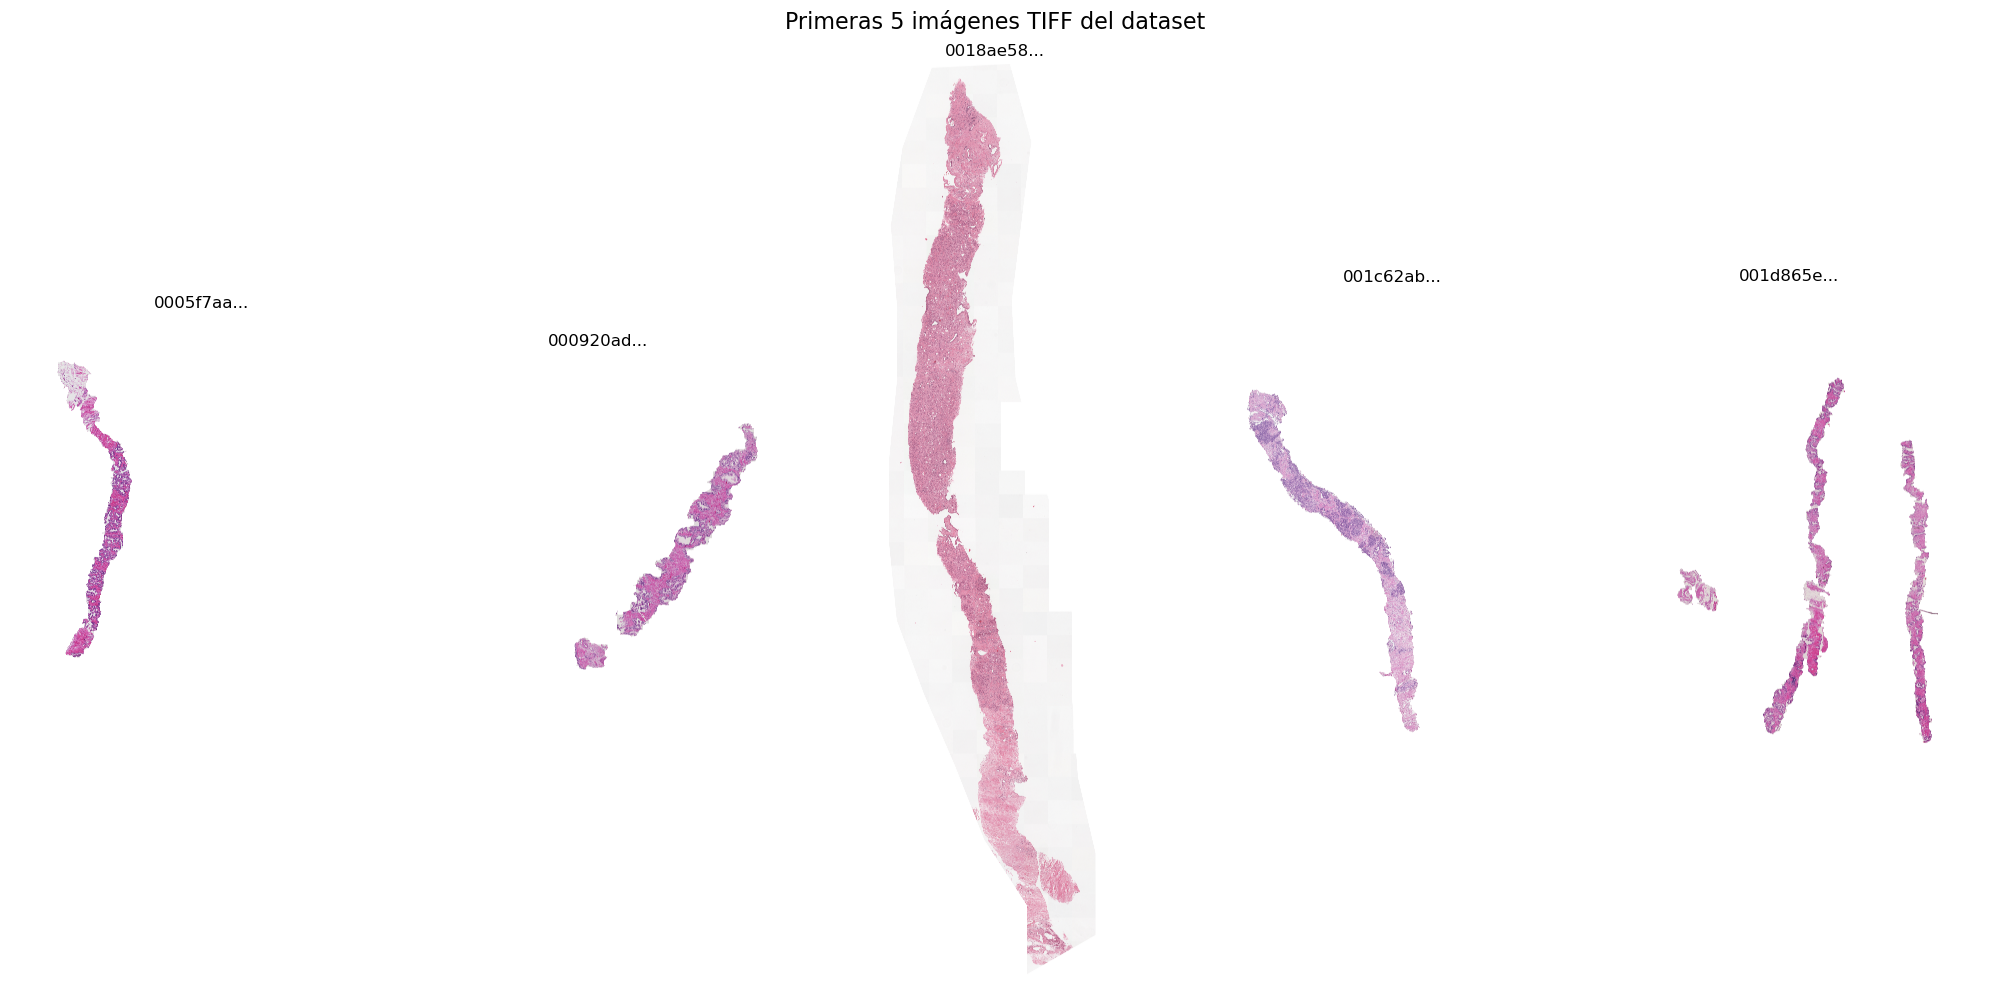

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Ruta a las imágenes .tiff
TIFF_DIR = "/data/datasets/PANDA/PANDA_original/original/train_images"

# Listar los primeros 5 archivos .tiff del directorio
tiff_files = sorted([f for f in os.listdir(TIFF_DIR) if f.endswith(".tiff")])[:5]
assert len(tiff_files) >= 5, f"Se encontraron solo {len(tiff_files)} archivos TIFF"

# Mostrar cada imagen
plt.figure(figsize=(20, 10))
for i, filename in enumerate(tiff_files):
    img_path = os.path.join(TIFF_DIR, filename)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(filename[:8] + "...")

plt.suptitle("Primeras 5 imágenes TIFF del dataset", fontsize=16)
plt.tight_layout()
plt.show()


In [7]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch
from tqdm import tqdm
from PIL import Image
from scripts.model import MILModel
from scripts.plot_utils import plot_wsi_and_heatmap, normalize  # Uso de plot_utils para visualización

# Aumentar límite de PIL para imágenes grandes
Image.MAX_IMAGE_PIXELS = None

# Configuración para guardar figuras
SAVE = True
SAVE_PATH = '/home/javitrucas/TFG/results/panda_heatmaps/'
FIGSIZE = (10, 10)
SAVE_EXTENSION = 'png'
os.makedirs(SAVE_PATH, exist_ok=True)
plt.rcParams.update({'font.size': 20})

# Paths de datos y modelo
DATA_DIR = '/data/datasets/PANDA/PANDA_original/original/'
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
MODEL_PATH = '/home/javitrucas/TFG/notebooks/models/panda/model_attention.pth'

# Parámetros
PATCH_SIZE = 512
RESIZE_SIZE = 112
MAX_PATCHES = 2000

# Funciones auxiliares faltantes
def load_image_safely(image_path, max_dimension=4096):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            scale_factor = 1.0
            if max(width, height) > max_dimension:
                scale_factor = max_dimension / max(width, height)
                img = img.resize((int(width*scale_factor), int(height*scale_factor)), Image.Resampling.LANCZOS)
            return np.array(img), scale_factor
    except Exception as e:
        print(f"Error cargando imagen: {e}")
        return None, 0


def extract_patches_from_wsi(image_path, patch_size=512, max_patches=2000):
    image_array, scale_factor = load_image_safely(image_path, max_dimension=6144)
    if image_array is None: return [], np.array([]), 0
    h, w = image_array.shape[:2]
    adj_size = max(64, int(patch_size * scale_factor))
    step = adj_size // 2
    ys = list(range(0, h - adj_size, step))
    xs = list(range(0, w - adj_size, step))
    # Submuestreo
    if len(ys)*len(xs) > max_patches:
        sq = int(np.sqrt(max_patches))
        ys = ys[::max(1, len(ys)//sq)]
        xs = xs[::max(1, len(xs)//sq)]
    patches, coords = [], []
    for y in ys:
        for x in xs:
            if len(patches) >= max_patches: break
            patch = image_array[y:y+adj_size, x:x+adj_size]
            if patch.shape[:2] != (adj_size, adj_size): continue
            if patch.mean() > 230: continue
            gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            if np.std(gray) < 5: continue
            patches.append(patch); coords.append([x, y])
        if len(patches) >= max_patches: break
    if len(patches) < 5:
        # Relajar filtros
        patches, coords = [], []
        for y in ys:
            for x in xs:
                if len(patches) >= max_patches: break
                patch = image_array[y:y+adj_size, x:x+adj_size]
                if patch.shape[:2] == (adj_size, adj_size):
                    patches.append(patch); coords.append([x, y])
            if len(patches) >= max_patches: break
    return patches, np.array(coords), adj_size


def create_canvas_from_patches(patches, coords, patch_size, resize_size=256):
    if len(patches) == 0: return np.zeros((512,512,3),dtype=np.uint8)+255, np.array([])
    # Normalizar coords a grilla
    coords_norm = coords.copy()
    if len(coords)>1:
        xs = np.unique(np.diff(np.sort(coords[:,0]))); ys = np.unique(np.diff(np.sort(coords[:,1])))
        step_x = xs[xs>0][0] if len(xs[xs>0])>0 else patch_size
        step_y = ys[ys>0][0] if len(ys[ys>0])>0 else patch_size
        coords_norm[:,0] = coords[:,0]//step_x; coords_norm[:,1] = coords[:,1]//step_y
    else:
        coords_norm = np.array([[0,0]])
    # Ajustar índices a 0
    coords_norm -= coords_norm.min(axis=0)
    max_x, max_y = coords_norm.max(axis=0)
    width = (max_x+1)*resize_size; height = (max_y+1)*resize_size
    canvas = np.ones((height, width,3),dtype=np.uint8)*255
    for i, patch in enumerate(patches):
        col,row = coords_norm[i]; y=row*resize_size; x=col*resize_size
        p = cv2.resize(patch,(resize_size,resize_size))
        canvas[y:y+resize_size, x:x+resize_size] = p
    # Cambiar a formato row,col
    coords_rc = coords_norm[:,[1,0]]
    return canvas, coords_rc

/tmp/ipykernel_2212205/948531502.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


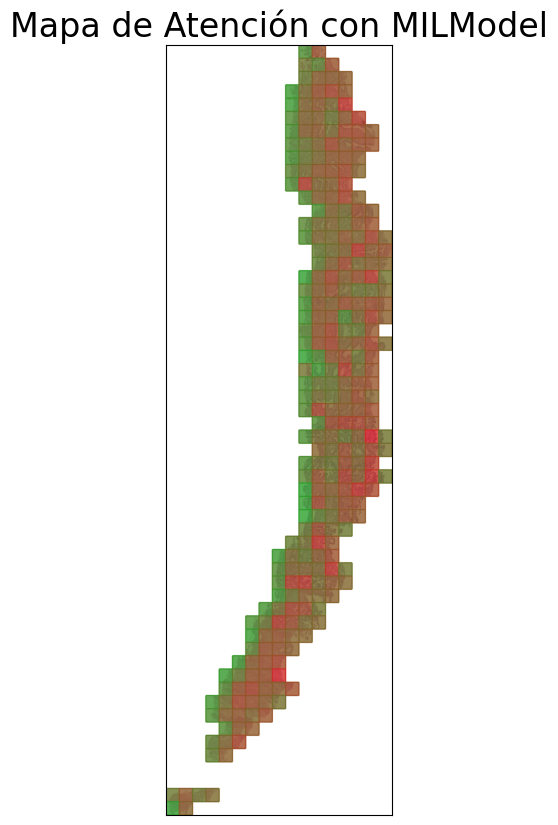

In [3]:
# Cargar CSV y seleccionar una WSI aleatoria positiva (o la primera si no hay)
df = pd.read_csv(CSV_PATH)
pos = df[df['isup_grade'] > 0]
sel = pos.sample(1).iloc[0] if len(pos) > 0 else df.iloc[0]
WSI_NAME = sel['image_id']
wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")

# Extraer parches y montar canvas
patches, coords_xy, psize = extract_patches_from_wsi(
    wsi_path,
    patch_size=PATCH_SIZE,
    max_patches=MAX_PATCHES
)
canvas, coords_rc = create_canvas_from_patches(
    patches,
    coords_xy,
    psize,
    RESIZE_SIZE
)

# Preparar tensores en escala de grises para el modelo (canal=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t_list = []
for p in patches:
    # 1) Redimensionar
    pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
    # 2) Pasar a gris y normalizar
    gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
    pn = gray.astype(np.float32) / 255.0
    # 3) Convertir en tensor con shape (1, H, W)
    t_list.append(torch.FloatTensor(pn).unsqueeze(0))
# Ahora t_list tiene N elementos de shape (1, H, W)
batch = torch.stack(t_list).unsqueeze(0).to(device)
# batch.shape == (1, N, 1, RESIZE_SIZE, RESIZE_SIZE)

# Cargar tu MILModel y pesos (strict=False para evitar cancelar por mismatch)
model = MILModel()
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

# Forward para obtener pesos de atención
with torch.no_grad():
    _, att = model(batch)
w = att.cpu().numpy().flatten()
w_norm = normalize(w)

# Plot del mapa de atención
fig, ax = plt.subplots(figsize=FIGSIZE)
plot_wsi_and_heatmap(
    ax,
    canvas,
    attval=w_norm,
    plot_patch_contour=True,
    size=RESIZE_SIZE,
    row_array=coords_rc[:, 0],
    col_array=coords_rc[:, 1]
)
ax.set_title('Mapa de Atención con MILModel')
if SAVE:
    plt.savefig(
        f"{SAVE_PATH}/panda_attention_MILModel.{SAVE_EXTENSION}",
        bbox_inches='tight',
        dpi=150
    )
plt.show()


INTENTO EXPLICATIVO

🔍 ANALIZANDO INSTANCIA POSITIVA

📊 Analizando INSTANCIA POSITIVA: d1c137944db51061ce5cf3ef82b1d8b5
🏷️  Etiqueta real: 1 (POSITIVO)


🔬 Parches extraídos: 174
🧠 Predicción del modelo: -0.0588 → NEGATIVO
❌ Predicción INCORRECTA
📍 Atención promedio: 0.555 ± 0.249
🎯 Zonas de alta atención: 3 de 174


/tmp/ipykernel_2212205/2675105620.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)
/tmp/ipykernel_2212205/267510

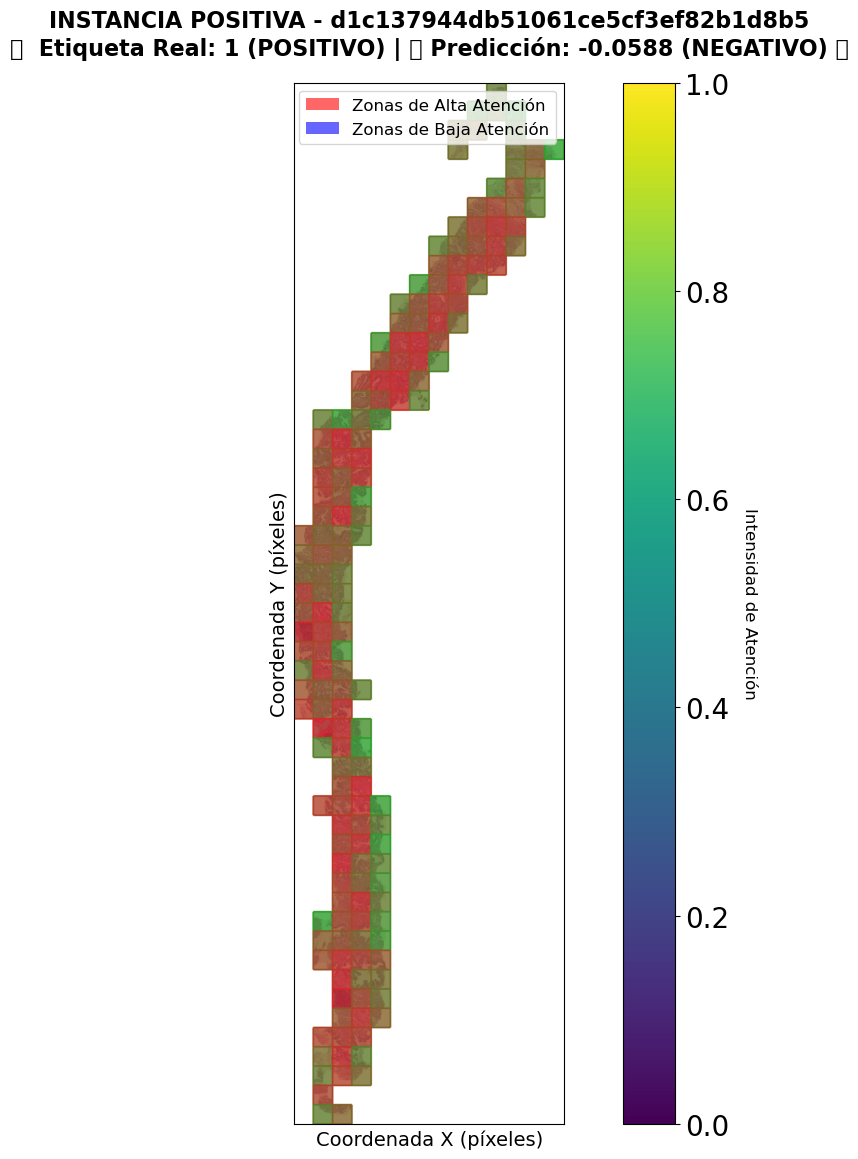

/tmp/ipykernel_2212205/2675105620.py:185: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2212205/2675105620.py:188: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{SAVE_PATH}/02_heatmap_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",


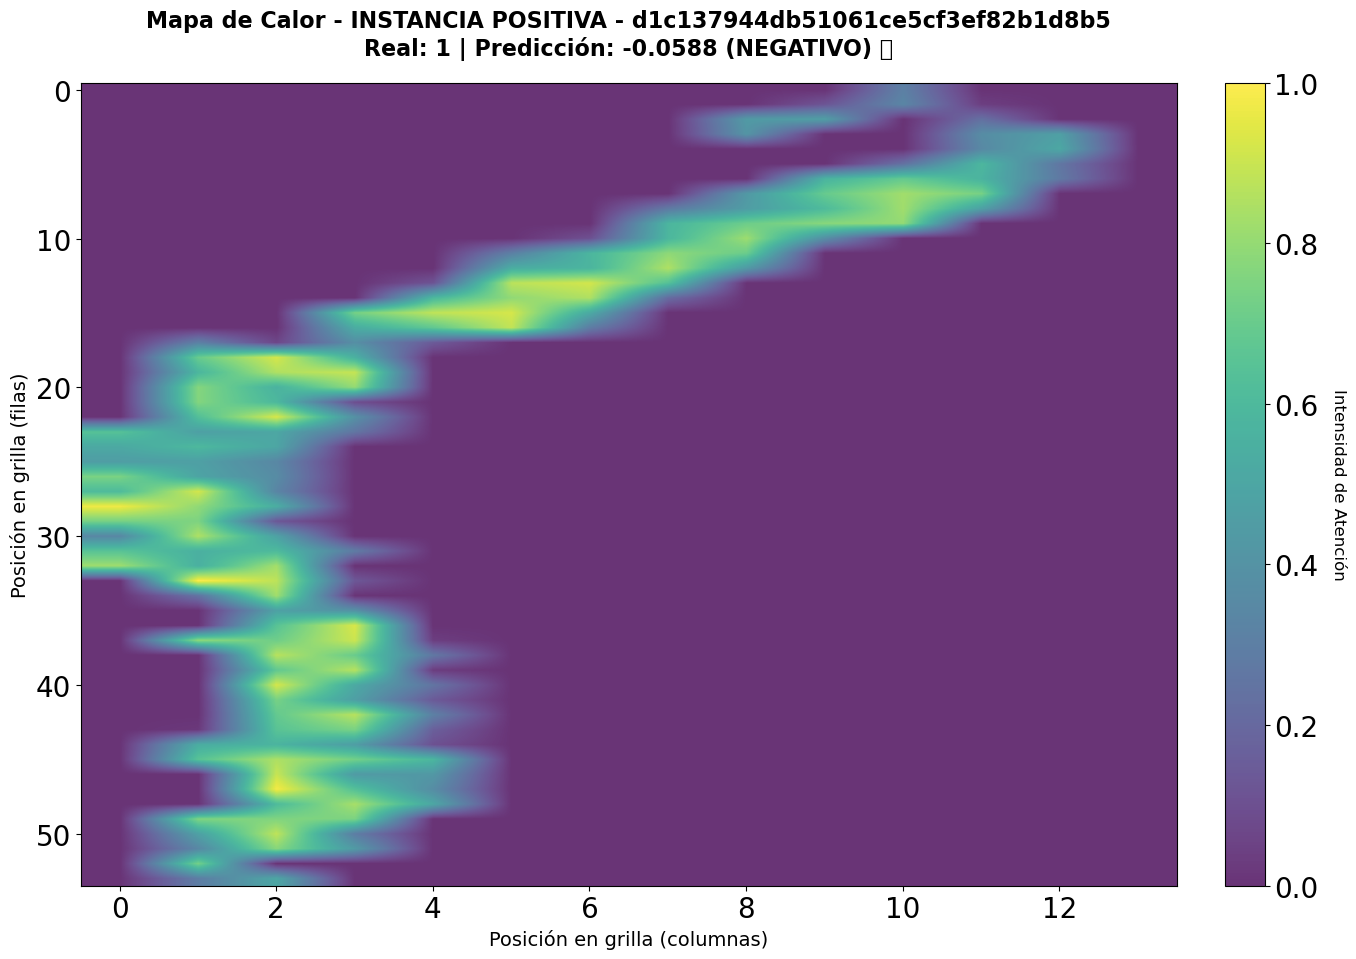

/tmp/ipykernel_2212205/2675105620.py:225: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2212205/2675105620.py:225: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2212205/2675105620.py:228: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{SAVE_PATH}/03_top_parches_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
/tmp/ipykernel_2212205/2675105620.py:228: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{SAVE_PATH}/03_top_parches_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


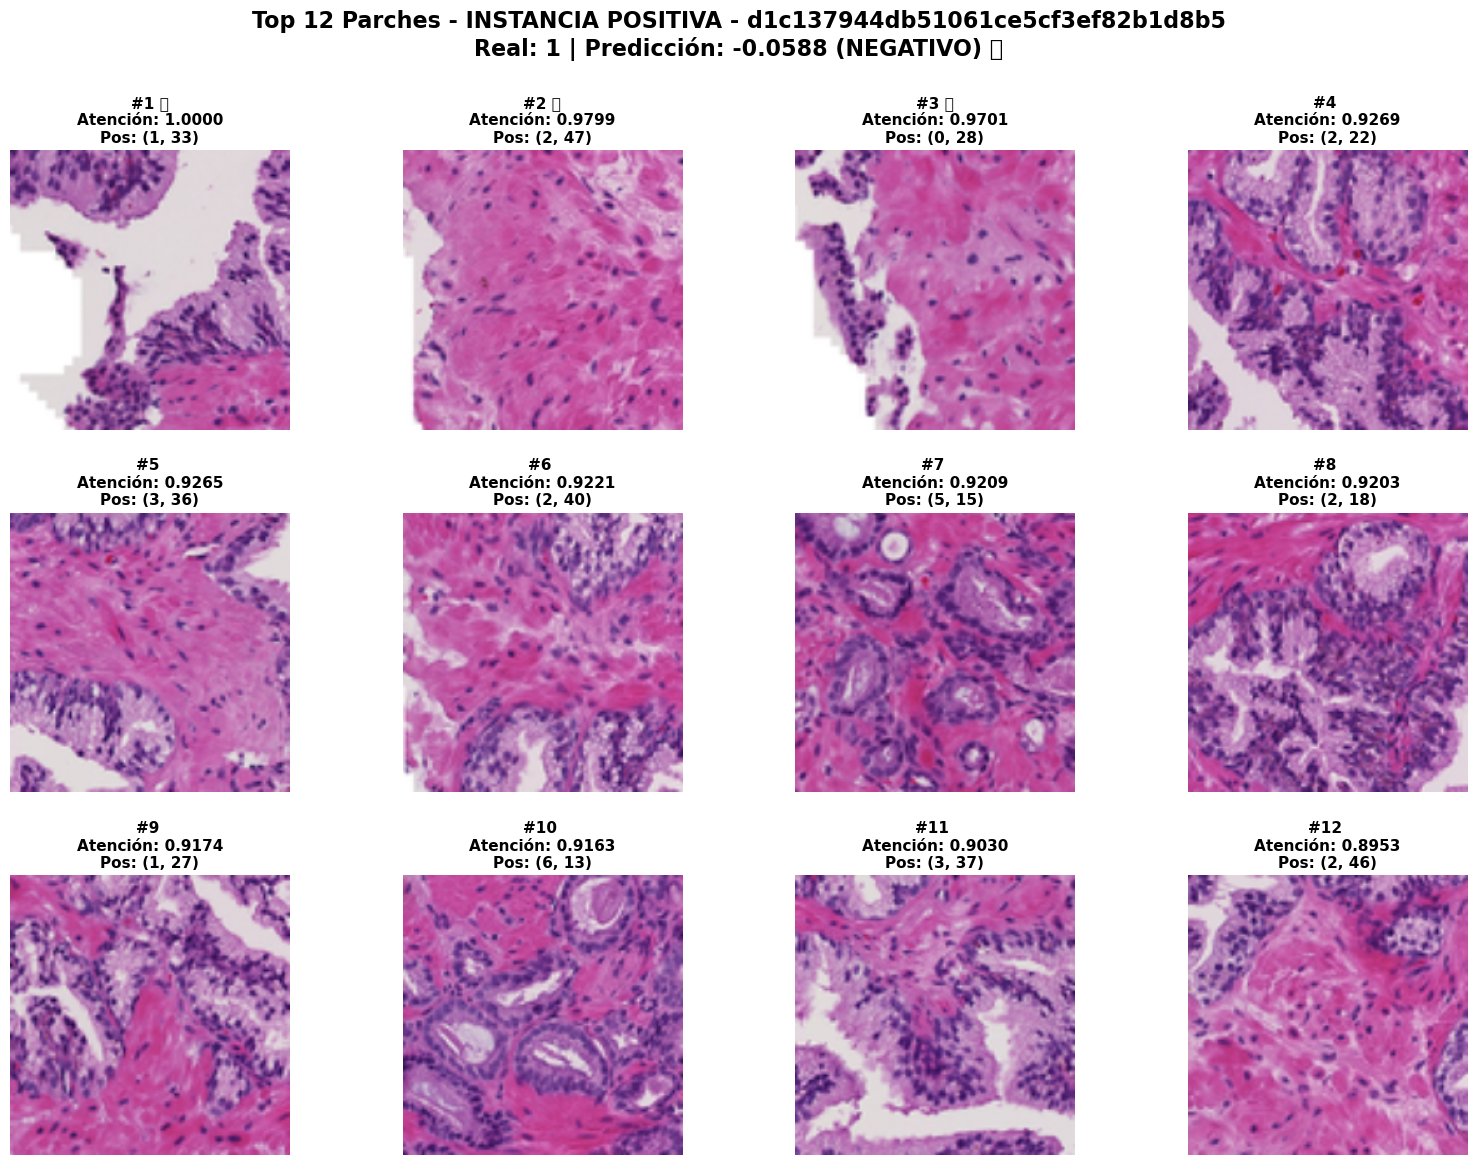

🔍 ANALIZANDO INSTANCIA NEGATIVA

📊 Analizando INSTANCIA NEGATIVA: c7e5735bcf728c93fa7dfcb24b975ead
🏷️  Etiqueta real: 0 (NEGATIVO)


In [ ]:
import sys
# setting path
sys.path.append('../')

def analyze_wsi_sample(sample_row, title_prefix=""):
    """Función para analizar una muestra WSI específica"""
    WSI_NAME = sample_row['image_id']
    wsi_path = os.path.join(TRAIN_IMAGES_DIR, f"{WSI_NAME}.tiff")
    true_label = int(sample_row['isup_grade'])
    
    print(f"\n📊 Analizando {title_prefix}: {WSI_NAME}")
    print(f"🏷️  Etiqueta real: {true_label} ({'POSITIVO' if true_label > 0 else 'NEGATIVO'})")

    # Extraer parches y montar canvas
    patches, coords_xy, psize = extract_patches_from_wsi(
        wsi_path,
        patch_size=PATCH_SIZE,
        max_patches=MAX_PATCHES
    )
    canvas, coords_rc = create_canvas_from_patches(
        patches,
        coords_xy,
        psize,
        RESIZE_SIZE
    )

    print(f"🔬 Parches extraídos: {len(patches)}")

    # Preparar tensores en escala de grises para el modelo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    t_list = []
    for p in patches:
        pr = cv2.resize(p, (RESIZE_SIZE, RESIZE_SIZE))
        gray = cv2.cvtColor(pr, cv2.COLOR_RGB2GRAY)
        pn = gray.astype(np.float32) / 255.0
        t_list.append(torch.FloatTensor(pn).unsqueeze(0))

    batch = torch.stack(t_list).unsqueeze(0).to(device)

    # Cargar modelo y obtener predicciones
    model = MILModel()
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    model.load_state_dict(checkpoint, strict=False)
    model.to(device)
    model.eval()

    with torch.no_grad():
        prediction, att = model(batch)
        
    w = att.cpu().numpy().flatten()
    w_norm = normalize(w)

    # Extraer valores escalares
    pred_value = float(prediction.cpu().numpy().flatten()[0])
    pred_class = "POSITIVO" if pred_value > 0.5 else "NEGATIVO"
    
    # Determinar si la predicción es correcta
    correct_pred = (pred_value > 0.5 and true_label > 0) or (pred_value <= 0.5 and true_label == 0)
    accuracy_symbol = "✅" if correct_pred else "❌"

    # Calcular estadísticas de atención
    att_stats = {
        'max': float(w_norm.max()),
        'min': float(w_norm.min()),
        'mean': float(w_norm.mean()),
        'std': float(w_norm.std())
    }

    print(f"🧠 Predicción del modelo: {pred_value:.4f} → {pred_class}")
    print(f"{accuracy_symbol} Predicción {'CORRECTA' if correct_pred else 'INCORRECTA'}")
    print(f"📍 Atención promedio: {att_stats['mean']:.3f} ± {att_stats['std']:.3f}")

    # Identificar zonas de alta atención
    high_attention_threshold = att_stats['mean'] + 1.5 * att_stats['std']
    high_att_indices = w_norm > high_attention_threshold

    print(f"🎯 Zonas de alta atención: {sum(high_att_indices)} de {len(w_norm)}")

    # =============================================================================
    # FIGURA 1: IMAGEN ORIGINAL CON MAPA DE ATENCIÓN SUPERPUESTO
    # =============================================================================
    plt.figure(figsize=(16, 12))
    ax = plt.gca()

    # Crear una versión modificada del canvas donde las zonas de alta atención se resaltan
    canvas_highlighted = canvas.copy()
    
    # Resaltar zonas de alta atención cambiando su color
    for i, is_high in enumerate(high_att_indices):
        if is_high:
            row, col = coords_rc[i]
            y_start = row * RESIZE_SIZE
            y_end = (row + 1) * RESIZE_SIZE
            x_start = col * RESIZE_SIZE
            x_end = (col + 1) * RESIZE_SIZE
            
            # Crear overlay rojo semitransparente
            overlay = canvas_highlighted[y_start:y_end, x_start:x_end].copy()
            overlay[:, :, 0] = np.minimum(255, overlay[:, :, 0] + 80)  # Más rojo
            overlay[:, :, 1] = np.maximum(0, overlay[:, :, 1] - 40)    # Menos verde
            overlay[:, :, 2] = np.maximum(0, overlay[:, :, 2] - 40)    # Menos azul
            canvas_highlighted[y_start:y_end, x_start:x_end] = overlay

    # Plot base con mapa de calor
    plot_wsi_and_heatmap(
        ax,
        canvas_highlighted,
        attval=w_norm,
        plot_patch_contour=True,
        size=RESIZE_SIZE,
        row_array=coords_rc[:, 0],
        col_array=coords_rc[:, 1]
    )

    # Título con información completa
    title = f'{title_prefix} - {WSI_NAME}\n'
    title += f'🏷️  Etiqueta Real: {true_label} ({("POSITIVO" if true_label > 0 else "NEGATIVO")})'
    title += f' | 🧠 Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Coordenada X (píxeles)', fontsize=14)
    ax.set_ylabel('Coordenada Y (píxeles)', fontsize=14)

    # Añadir leyenda personalizada
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.6, label='Zonas de Alta Atención'),
        Patch(facecolor='blue', alpha=0.6, label='Zonas de Baja Atención')
    ]
    ax.legend(handles=legend_elements, fontsize=12, loc='upper right')

    # Añadir barra de colores
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    norm = Normalize(vmin=w_norm.min(), vmax=w_norm.max())
    sm = ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Intensidad de Atención', fontsize=12, rotation=270, labelpad=20)

    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/01_mapa_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # =============================================================================
    # FIGURA 2: MAPA DE CALOR PURO CON ZONAS RESALTADAS
    # =============================================================================
    plt.figure(figsize=(14, 10))

    # Crear grilla para el heatmap
    grid_h = coords_rc[:, 0].max() + 1
    grid_w = coords_rc[:, 1].max() + 1
    heatmap_grid = np.zeros((grid_h, grid_w))
    
    # Crear máscara para zonas de alta atención
    high_attention_mask = np.zeros((grid_h, grid_w))
    
    for i, (r, c) in enumerate(coords_rc):
        heatmap_grid[r, c] = w_norm[i]
        if high_att_indices[i]:
            high_attention_mask[r, c] = 1

    # Plot del heatmap base
    im = plt.imshow(heatmap_grid, cmap='viridis', aspect='auto', interpolation='bilinear', alpha=0.8)
    
    # Superponer zonas de alta atención con color diferente
    high_att_colored = np.ma.masked_where(high_attention_mask == 0, high_attention_mask)
    plt.imshow(high_att_colored, cmap='Reds', aspect='auto', interpolation='bilinear', alpha=0.7)

    # Título con información completa
    title = f'Mapa de Calor - {title_prefix} - {WSI_NAME}\n'
    title += f'Real: {true_label} | Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Posición en grilla (columnas)', fontsize=14)
    plt.ylabel('Posición en grilla (filas)', fontsize=14)

    # Barra de colores
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Intensidad de Atención', fontsize=12, rotation=270, labelpad=20)

    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/02_heatmap_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # =============================================================================
    # FIGURA 3: TOP PARCHES CON MAYOR ATENCIÓN
    # =============================================================================
    plt.figure(figsize=(16, 12))

    # Obtener top 12 parches
    top_indices = np.argsort(w_norm)[-12:][::-1]
    rows, cols = 3, 4

    for i, idx in enumerate(top_indices):
        ax = plt.subplot(rows, cols, i+1)
        
        # Mostrar parche
        patch_resized = cv2.resize(patches[idx], (224, 224))
        ax.imshow(patch_resized)
        
        # Título con información
        is_high_att = "🔥" if high_att_indices[idx] else ""
        ax.set_title(f'#{i+1} {is_high_att}\nAtención: {w_norm[idx]:.4f}\nPos: ({coords_rc[idx, 1]}, {coords_rc[idx, 0]})', 
                    fontsize=11, fontweight='bold')
        ax.axis('off')
        
        # Destacar zonas de alta atención con borde rojo
        if high_att_indices[idx]:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(4)

    # Título con información completa
    suptitle = f'Top 12 Parches - {title_prefix} - {WSI_NAME}\n'
    suptitle += f'Real: {true_label} | Predicción: {pred_value:.4f} ({pred_class}) {accuracy_symbol}'
    
    plt.suptitle(suptitle, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    if SAVE:
        safe_title = title_prefix.replace(" ", "_").lower()
        plt.savefig(f"{SAVE_PATH}/03_top_parches_{safe_title}_{WSI_NAME}.{SAVE_EXTENSION}",
                    bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

    # Retornar estadísticas para el reporte
    return {
        'wsi_name': WSI_NAME,
        'true_label': true_label,
        'prediction': pred_value,
        'pred_class': pred_class,
        'correct': correct_pred,
        'att_stats': att_stats,
        'high_att_count': sum(high_att_indices),
        'total_patches': len(patches)
    }

# =============================================================================
# ANÁLISIS PRINCIPAL: SELECCIONAR CASOS POSITIVO Y NEGATIVO
# =============================================================================

# Cargar CSV
df = pd.read_csv(CSV_PATH)

# Seleccionar una instancia positiva (ISUP > 0)
positive_cases = df[df['isup_grade'] > 0]
if len(positive_cases) > 0:
    positive_sample = positive_cases.sample(1).iloc[0]
    print("="*70)
    print("🔍 ANALIZANDO INSTANCIA POSITIVA")
    print("="*70)
    pos_results = analyze_wsi_sample(positive_sample, "INSTANCIA POSITIVA")
else:
    print("❌ No se encontraron casos positivos en el dataset")
    pos_results = None

# Seleccionar una instancia negativa (ISUP = 0)
negative_cases = df[df['isup_grade'] == 0]
if len(negative_cases) > 0:
    negative_sample = negative_cases.sample(1).iloc[0]
    print("="*70)
    print("🔍 ANALIZANDO INSTANCIA NEGATIVA")
    print("="*70)
    neg_results = analyze_wsi_sample(negative_sample, "INSTANCIA NEGATIVA")
else:
    print("❌ No se encontraron casos negativos en el dataset")
    neg_results = None

# =============================================================================
# REPORTE COMPARATIVO FINAL
# =============================================================================
print("\n" + "="*80)
print("📋 REPORTE COMPARATIVO FINAL")
print("="*80)

if pos_results:
    print(f"\n🟢 INSTANCIA POSITIVA:")
    print(f"   📄 Muestra: {pos_results['wsi_name']}")
    print(f"   🏷️  Etiqueta real: {pos_results['true_label']}")
    print(f"   🧠 Predicción: {pos_results['prediction']:.6f} → {pos_results['pred_class']}")
    print(f"   {'✅' if pos_results['correct'] else '❌'} {'CORRECTA' if pos_results['correct'] else 'INCORRECTA'}")
    print(f"   📊 Parches: {pos_results['total_patches']}")
    print(f"   🎯 Alta atención: {pos_results['high_att_count']} ({100*pos_results['high_att_count']/pos_results['total_patches']:.1f}%)")

if neg_results:
    print(f"\n🔴 INSTANCIA NEGATIVA:")
    print(f"   📄 Muestra: {neg_results['wsi_name']}")
    print(f"   🏷️  Etiqueta real: {neg_results['true_label']}")
    print(f"   🧠 Predicción: {neg_results['prediction']:.6f} → {neg_results['pred_class']}")
    print(f"   {'✅' if neg_results['correct'] else '❌'} {'CORRECTA' if neg_results['correct'] else 'INCORRECTA'}")
    print(f"   📊 Parches: {neg_results['total_patches']}")
    print(f"   🎯 Alta atención: {neg_results['high_att_count']} ({100*neg_results['high_att_count']/neg_results['total_patches']:.1f}%)")

if pos_results and neg_results:
    print(f"\n📈 COMPARACIÓN:")
    print(f"   🎯 Diferencia en predicción: {abs(pos_results['prediction'] - neg_results['prediction']):.4f}")
    print(f"   📊 Diferencia en alta atención: {abs(pos_results['high_att_count'] - neg_results['high_att_count'])} parches")

print(f"\n💾 Todas las figuras guardadas en: {SAVE_PATH}")
print("="*80)